In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import keras
import keras_cv
import pickle
from tqdm.notebook import tqdm
import time
import onnxruntime as ort
import tf2onnx
import onnx
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras_cv.src.backend import ops
from keras_cv.src import bounding_box

tf.config.list_physical_devices('GPU')

2024-06-09 21:54:39.264808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 21:54:39.264859: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 21:54:39.264881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
def data_generator(data_path, split_data, split_type):
    for file_path, mask in split_data[split_type]:
        image = tf.io.read_file(tf.strings.join([data_path, file_path]))
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.uint8)

        num_boxes = len(mask)

        boxes = tf.convert_to_tensor(mask, dtype=tf.float32)

        classes = tf.random.uniform([num_boxes], dtype=tf.int32, minval=0, maxval=2)

        bounding_boxes = {"classes": classes, "boxes": boxes}

        data = {"images": image, "bounding_boxes": bounding_boxes}

        yield data


def preprocess_data(data_path, split_data, split_type, BATCH_SIZE, IMAGE_WH):
    def data_generator(data_path, split_data, split_type):
        for file_path, mask in split_data[split_type]:
            image = tf.io.read_file(tf.strings.join([data_path, file_path]))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.uint8)

            num_boxes = len(mask)

            boxes = tf.convert_to_tensor(mask, dtype=tf.float32)

            classes = tf.zeros([num_boxes], dtype=tf.int8)

            bounding_boxes = {"classes": classes, "boxes": boxes}

            data = {"images": image, "bounding_boxes": bounding_boxes}

            yield data

    o_s = {
        "images": tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        # 'boxes': tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
        "bounding_boxes": {
            "classes": tf.TensorSpec(shape=(None,), dtype=tf.int32),
            "boxes": tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
        },
    }

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(data_path, split_data, split_type), output_signature=o_s
    )
    dataset = dataset.ragged_batch(BATCH_SIZE, drop_remainder=True)

    resizing = keras_cv.layers.Resizing(
        height=IMAGE_WH[0],
        width=IMAGE_WH[1],
        pad_to_aspect_ratio=True,
        bounding_box_format="xywh",
    )

    dataset = dataset.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

    def dict_to_tuple(inputs):
        return inputs["images"], keras_cv.bounding_box.to_dense(
            inputs["bounding_boxes"], max_boxes=64
        )

    dataset = dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


def preprocess_one_image_and_bboxes(image_path_and_bboxes, IMAGE_WH):
    image_path, bboxes = image_path_and_bboxes
    image_path = "../2lab/data/WIDER_train/images/" + image_path

    image = tf.keras.utils.load_img(image_path)
    image = tf.keras.utils.img_to_array(image)
    image = tf.expand_dims(image, axis=0)

    num_boxes = len(bboxes)
    classes = tf.zeros([num_boxes], dtype=tf.int8)
    bboxes = tf.convert_to_tensor(bboxes, dtype=tf.float32)

    bounding_boxes = {
        "classes": tf.expand_dims(classes, axis=0),
        "boxes": tf.expand_dims(bboxes, axis=0),
    }
    data = {"images": image, "bounding_boxes": bounding_boxes}

    resizing = keras_cv.layers.Resizing(
        height=640,
        width=640,
        pad_to_aspect_ratio=True,
        bounding_box_format="xywh",
    )
    data = resizing(data)
    return data


def printsize(path):
    print(
        f"{path} - {os.path.getsize(path) / 2**10 / 2**10:.2f} МБ"
    )


def evaluate_model_keras(path_to_model, data, show = True):
    model = keras.saving.load_model(path_to_model)
    metric = keras_cv.metrics.BoxCOCOMetrics(
        bounding_box_format="xywh",
        evaluate_freq=1e9,
    )
    metric.reset_state()
    times = []
    for batch in tqdm(data, total=len(split_data['test'])):
        images, y_true = batch[0], batch[1]
        s = time.time()
        y_pred = model.predict(images, verbose=0)
        e = time.time()
        times.append(e - s)
        metric.update_state(y_true, y_pred)
    metric = metric.result(force=True)
    metric = {key: tf.squeeze(value).numpy() for key, value in metric.items()}
    metric["Pred time"] = sum(times) / len(times)

    if show: 
        print(f"MaP: {metric['MaP']:.4f}\nAverage time for prediction (4bs): {metric['Pred time']:.4f}")

    return metric

def evaluate_model_onnx(onnx_sess, data, show = True):
    metric = keras_cv.metrics.BoxCOCOMetrics(
        bounding_box_format="xywh",
        evaluate_freq=1e9,
    )
    metric.reset_state()
    times = []
    for batch in tqdm(data, total=len(split_data['test'])):
        images, y_true = batch[0], batch[1]
        s = time.time()
        y_pred = onnx_sess.run(output_names=None, input_feed= {'input': images.numpy()})
        y_pred = decode_predictions(prediction_decoder, y_pred, images)
        e = time.time()
        times.append(e - s)
        metric.update_state(y_true, y_pred)
    metric = metric.result(force=True)
    metric = {key: tf.squeeze(value).numpy() for key, value in metric.items()}
    metric["Pred time"] = sum(times) / len(times)
    
    if show: 
        print(f"MaP: {metric['MaP']:.4f}\nAverage time for prediction (4bs): {metric['Pred time']:.4f}")

    return metric


def plot_predictions_gallery(data, y_pred1, y_pred2, model1, model2):
    image = data["images"]
    bboxes = data["bounding_boxes"]["boxes"].numpy()[0]
    y_pred_bboxes1 = y_pred1['boxes'][0]
    y_pred_bboxes2 = y_pred1['boxes'][0]
    image_uint8 = tf.cast(image, dtype=tf.uint8).numpy()[0]
    
    fig, ax = plt.subplots(1, figsize = (10, 10))
    ax.imshow(image_uint8)
    ax.axis('off')

    for bbox in bboxes:
        x, y, w, h = bbox
        if x == -1 and y == -1:
            break
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor="none", alpha = 1)
        ax.add_patch(rect)

    for bbox in y_pred_bboxes1:
        x, y, w, h = bbox
        if x == -1 and y == -1:
            break
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='y', facecolor="none", alpha = 1)
        ax.add_patch(rect)

    for bbox in y_pred_bboxes2:
        x, y, w, h = bbox
        if x == -1 and y == -1:
            break
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor="none", alpha = 1)
        ax.add_patch(rect)
    
    plt.show()

BOX_REGRESSION_CHANNELS = 64

def decode_regression_to_boxes(preds):
    """Decodes the results of the YOLOV8Detector forward-pass into boxes.

    Returns left / top / right / bottom predictions with respect to anchor
    points.

    Each coordinate is encoded with 16 predicted values. Those predictions are
    softmaxed and multiplied by [0..15] to make predictions. The resulting
    predictions are relative to the stride of an anchor box (and correspondingly
    relative to the scale of the feature map from which the predictions came).
    """
    preds_bbox = keras.layers.Reshape((-1, 4, BOX_REGRESSION_CHANNELS // 4))(
        preds
    )
    preds_bbox = ops.nn.softmax(preds_bbox, axis=-1) * ops.arange(
        BOX_REGRESSION_CHANNELS // 4, dtype="float32"
    )
    return ops.sum(preds_bbox, axis=-1)

def get_anchors(
    image_shape,
    strides=[8, 16, 32],
    base_anchors=[0.5, 0.5],
):
    """Gets anchor points for YOLOV8.

    YOLOV8 uses anchor points representing the center of proposed boxes, and
    matches ground truth boxes to anchors based on center points.

    Args:
        image_shape: tuple or list of two integers representing the height and
            width of input images, respectively.
        strides: tuple of list of integers, the size of the strides across the
            image size that should be used to create anchors.
        base_anchors: tuple or list of two integers representing the offset from
            (0,0) to start creating the center of anchor boxes, relative to the
            stride. For example, using the default (0.5, 0.5) creates the first
            anchor box for each stride such that its center is half of a stride
            from the edge of the image.

    Returns:
        A tuple of anchor centerpoints and anchor strides. Multiplying the
        two together will yield the centerpoints in absolute x,y format.

    """
    base_anchors = ops.array(base_anchors, dtype="float32")

    all_anchors = []
    all_strides = []
    for stride in strides:
        hh_centers = ops.arange(0, image_shape[0], stride)
        ww_centers = ops.arange(0, image_shape[1], stride)
        ww_grid, hh_grid = ops.meshgrid(ww_centers, hh_centers)
        grid = ops.cast(
            ops.reshape(ops.stack([hh_grid, ww_grid], 2), [-1, 1, 2]),
            "float32",
        )
        anchors = (
            ops.expand_dims(
                base_anchors * ops.array([stride, stride], "float32"), 0
            )
            + grid
        )
        anchors = ops.reshape(anchors, [-1, 2])
        all_anchors.append(anchors)
        all_strides.append(ops.repeat(stride, anchors.shape[0]))

    all_anchors = ops.cast(ops.concatenate(all_anchors, axis=0), "float32")
    all_strides = ops.cast(ops.concatenate(all_strides, axis=0), "float32")

    all_anchors = all_anchors / all_strides[:, None]

    # Swap the x and y coordinates of the anchors.
    all_anchors = ops.concatenate(
        [all_anchors[:, 1, None], all_anchors[:, 0, None]], axis=-1
    )
    return all_anchors, all_strides

def dist2bbox(distance, anchor_points):
    """Decodes distance predictions into xyxy boxes.

    Input left / top / right / bottom predictions are transformed into xyxy box
    predictions based on anchor points.

    The resulting xyxy predictions must be scaled by the stride of their
    corresponding anchor points to yield an absolute xyxy box.
    """
    left_top, right_bottom = ops.split(distance, 2, axis=-1)
    x1y1 = anchor_points - left_top
    x2y2 = anchor_points + right_bottom
    return ops.concatenate((x1y1, x2y2), axis=-1)  # xyxy bbox

def decode_predictions(prediction_decoder, pred, images):
        boxes = pred[0]
        scores = pred[1]

        boxes = decode_regression_to_boxes(boxes)

        anchor_points, stride_tensor = get_anchors(image_shape=images.shape[1:])
        stride_tensor = ops.expand_dims(stride_tensor, axis=-1)

        box_preds = dist2bbox(boxes, anchor_points) * stride_tensor
        box_preds = bounding_box.convert_format(
            box_preds,
            source="xyxy",
            target="xywh",
            images=images,
        )

        return prediction_decoder(box_preds, scores)

prediction_decoder = keras_cv.layers.NonMaxSuppression(
                bounding_box_format='xywh',
                from_logits=False,
                confidence_threshold=0.2,
                iou_threshold=0.7,
            )

def predict_onnx(onnx_sess, image, prediction_decoder):
    y_pred = onnx_sess.run(output_names=None, input_feed= {'input': image.numpy()})
    y_pred = decode_predictions(prediction_decoder, y_pred, image)
    return y_pred

In [3]:
with open('spit_data0_01.pkl', 'rb') as file:
    split_data = pickle.load(file)
print(f"{' '.join(map(str, [f'{x} {len(split_data[x])}' for x in split_data.keys()]))}")
test_dataset = preprocess_data('../2lab/data/WIDER_train/images/', split_data, 'test', 1, (640, 640)) 

train 4990 val 619 test 672


In [4]:
printsize('final_model_yolov8s_af_bs16_e50.keras')

final_model_yolov8s_af_bs16_e50.keras - 151.81 МБ


In [5]:
results_keras = evaluate_model_keras('final_model_yolov8s_best_bs16_e50.keras', test_dataset)

/home/bob/miniconda3/envs/tf2.14/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/bob/miniconda3/envs/tf2.14/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


  0%|          | 0/672 [00:00<?, ?it/s]

MaP: 0.6038
Average time for prediction (4bs): 0.2019


# ONNX 

In [6]:
%%script echo already done
keras_model = keras.saving.load_model("final_model_yolov8s_best_bs16_e50.keras")
input_signature = [
    tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name="input")
]
onnx_model, _ = tf2onnx.convert.from_keras(keras_model, input_signature, opset=13)
onnx.save(onnx_model, "final_model_yolov8s_best_bs16_e50.onnx")

already done


In [7]:
printsize('final_model_yolov8s_best_bs16_e50.onnx')
printsize('final_model_yolov8s_best_bs16_e50.keras')

final_model_yolov8s_best_bs16_e50.onnx - 50.36 МБ
final_model_yolov8s_best_bs16_e50.keras - 151.81 МБ


In [8]:
sess = ort.InferenceSession("final_model_yolov8s_best_bs16_e50.onnx", providers=["CUDAExecutionProvider"])
results_onnx = evaluate_model_onnx(sess, test_dataset)

2024-06-09 21:57:14.230252550 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-06-09 21:57:14.230285422 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


  0%|          | 0/672 [00:00<?, ?it/s]

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/home/bob/miniconda3/envs/tf2.14/lib/python3.10/asyncio/unix_events.py", line 676, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


MaP: 0.6038
Average time for prediction (4bs): 0.2401


In [9]:
%%script echo not necessary 
bad = [4, 6, 78, 492]
good = [11, 3, 2, 14]
for i in bad:
    data = preprocess_one_image_and_bboxes(split_data['test'][i], (640, 640))
    show_predictions(model = None, data = data, bbox_format = 'xywh', onnx_sess=sess, prediction_decoder=prediction_decoder)

not necessary


In [14]:
from keras_cv import visualization
from IPython.display import display, HTML

def compare_detections(keras_model, onnx_sess, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred1 = keras_model.predict(images, verbose=0)
    y_pred2 = predict_onnx(onnx_sess, images, prediction_decoder)
    display(HTML("<h1>Keras</h1>"))
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred1,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
    )
    display(HTML("<h1>Onnx</h1>"))
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred2,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
    )

def show_predictions(model, data, bbox_format, onnx_sess = None, prediction_decoder = None):
    images = data['images']
    y_true = data['bounding_boxes']
    if not onnx_sess:
        y_pred = model.predict(images)
    else:
        y_pred = predict_onnx(onnx_sess, images, prediction_decoder)

    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bbox_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
    )

/home/bob/miniconda3/envs/tf2.14/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/bob/miniconda3/envs/tf2.14/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


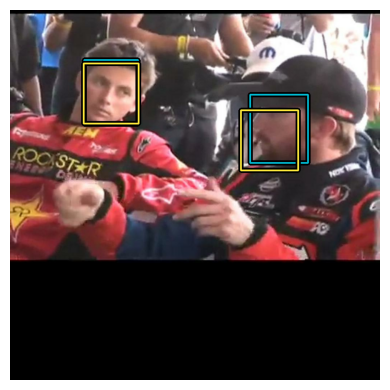

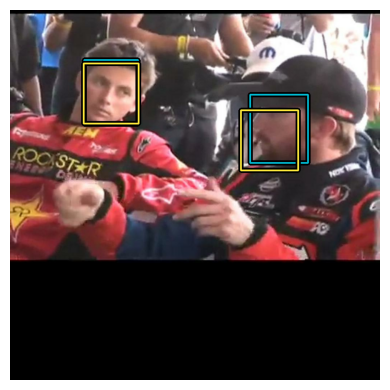

In [15]:
keras_model = keras.saving.load_model('final_model_yolov8s_best_bs16_e50.keras')
test_dataset = test_dataset.shuffle(4)
compare_detections(keras_model, sess, test_dataset, 'xywh')

# Bento ML

In [ ]:
import bentoml
from PIL import Image
import timeit
from random import randint

client = bentoml.SyncHTTPClient('http://localhost:3000')

def job(n):
    client.predict(input_image = '../2lab/data/WIDER_train/images/' + split_data['test'][n][0])

time = timeit.timeit("job(randint(0, 671))", globals=globals(), number = 100)
client.close()

print(f'Время на 1 предсказание: {time/100:.4f} c')

Время: 0.4331 c
